In [1]:
import torch

from my_extension import my_extension as myext

%autoreload 2

In [2]:
# print(myext.linear_cpp_precompiled.__file__)  # pre-compiled with `python setup.py install`
# print(myext.linear_cpp_precompiled.forward)

In [3]:
# print(myext.backend.__file__)
print(myext._C.__file__)  # JIT using `load()` in csrc submodule
print(myext._C.forward)

/home/techix/.cache/torch_extensions/py310_cu117/linear_cpp/linear_cpp.so
<built-in method forward of PyCapsule object at 0x7f13b0c8a7c0>


In [4]:
print(myext._CU.__file__)  # JIT using `load()` in csrc submodule
print(myext._CU.forward)

/home/techix/.cache/torch_extensions/py310_cu117/linear_cuda/linear_cuda.so
<built-in method forward of PyCapsule object at 0x7f13b0c8a4f0>


In [5]:
torch.manual_seed(0)
device = 'cuda:0'
n_h = 3
n_in = 2
n_batch = 1

# X = torch.ones(n_batch, n_in, device=device)
X = torch.randn(n_batch, n_in, device=device)
print(X.shape)

torch.Size([1, 2])


In [6]:
## Setup models
lin_gt = torch.nn.Linear(n_in, n_h, device=device)
z1_gt = lin_gt(X)
# print(z1_py.shape, '\n', z1_py)

W1, b1 = lin_gt.parameters()
print(W1, b1)
print(z1_gt.grad_fn)

Parameter containing:
tensor([[ 0.6678,  0.4115],
        [-0.0438, -0.2404],
        [-0.2341, -0.1721]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-0.6796,  0.3866,  0.5163], device='cuda:0', requires_grad=True)


In [7]:
## Check LinearPytorch forward method
W1_py, b1_py = W1.detach().clone(), b1.detach().clone()
W1_py.requires_grad = True
b1_py.requires_grad = True
lin_py = myext.LinearPytorch()
z1_py = lin_py.apply(X, W1_py, b1_py)
print(z1_py.shape)
print(z1_py.shape)
torch.testing.assert_close(z1_gt, z1_py)

torch.Size([1, 3])
torch.Size([1, 3])


In [8]:
## Check LinearPytorch backward method
abs(z1_gt.sum()).backward(retain_graph=True)
print(W1.grad, b1.grad)

abs(z1_py.sum()).backward(retain_graph=True)
print(W1_py.grad, b1_py.grad)

torch.testing.assert_close(W1.grad, W1_py.grad)
torch.testing.assert_close(b1.grad, b1_py.grad)

tensor([[0.9247, 0.4253],
        [0.9247, 0.4253],
        [0.9247, 0.4253]], device='cuda:0') tensor([-1., -1., -1.], device='cuda:0')
tensor([[0.9247, 0.4253],
        [0.9247, 0.4253],
        [0.9247, 0.4253]], device='cuda:0') tensor([-1., -1., -1.], device='cuda:0')


In [9]:
## Check LinearCPP forward method
W1_cpp, b1_cpp = W1.detach().clone(), b1.detach().clone()
W1_cpp.requires_grad = True
b1_cpp.requires_grad = True
lin_cpp = myext.LinearCPP()
z1_cpp = lin_cpp.apply(X, W1_cpp, b1_cpp)
print(z1_gt.shape)
print(z1_cpp.shape)
torch.testing.assert_close(z1_gt, z1_cpp)

torch.Size([1, 3])
torch.Size([1, 3])


In [10]:
## Check LinearCPP backward method
abs(z1_gt.sum()).backward(retain_graph=True)
print(W1.grad, b1.grad)

abs(z1_cpp.sum()).backward(retain_graph=True)
print(W1_cpp.grad, b1_cpp.grad)

# torch.testing.assert_close(W1.grad, -W1_cpp.grad)
# torch.testing.assert_close(b1.grad, -b1_cpp.grad)

tensor([[1.8493, 0.8507],
        [1.8493, 0.8507],
        [1.8493, 0.8507]], device='cuda:0') tensor([-2., -2., -2.], device='cuda:0')
tensor([[0.9247, 0.4253],
        [0.9247, 0.4253],
        [0.9247, 0.4253]], device='cuda:0') tensor([-1., -1., -1.], device='cuda:0')


In [11]:
## Check LinearCuda forward method
W1_cuda, b1_cuda = W1.detach().clone(), b1.detach().clone()
W1_cuda.requires_grad = True
b1_cuda.requires_grad = True
lin_cuda = myext.LinearCuda()
z1_cuda = lin_cuda.apply(X, W1_cuda, b1_cuda)
print(z1_gt.shape)
print(z1_cuda.shape)
print(z1_gt, "\n", z1_cuda)
torch.testing.assert_close(z1_gt, z1_cuda)

torch.Size([1, 3])
torch.Size([1, 3])
tensor([[-1.4722,  0.5293,  0.8059]], device='cuda:0',
       grad_fn=<AddmmBackward0>) 
 tensor([[-1.4722,  0.5293,  0.8059]], device='cuda:0',
       grad_fn=<LinearCudaBackward>)


In [12]:
## Check LinearCuda backward method
abs(z1_gt.sum()).backward(retain_graph=True)
print(W1.grad, b1.grad)

abs(z1_cuda.sum()).backward(retain_graph=True)
print(W1_cuda.grad, b1_cuda.grad)

# torch.testing.assert_close(W1.grad, -W1_cuda.grad)
# torch.testing.assert_close(b1.grad, -b1_cuda.grad)

tensor([[2.7740, 1.2760],
        [2.7740, 1.2760],
        [2.7740, 1.2760]], device='cuda:0') tensor([-3., -3., -3.], device='cuda:0')
tensor([[0.9247, 0.4253],
        [0.9247, 0.4253],
        [0.9247, 0.4253]], device='cuda:0') tensor([-1., -1., -1.], device='cuda:0')


In [13]:
# model_forward = lin_gt.forward
# parameters = list(lin_gt.parameters())

# model_forward = lin_py.apply
# parameters = (W1_py, b1_py)

# model_forward = lin_cpp.apply
# parameters = (W1_cpp, b1_cpp)

model_forward = lin_cuda.apply
parameters = (W1_cuda, b1_cuda)

optimizer = torch.optim.SGD(parameters, lr=1e-3)

In [14]:
## Single optimizer step
z1 = model_forward(X, *parameters)
loss = abs(z1.sum())

loss.backward()
optimizer.step()
optimizer.zero_grad()

print(loss.item())
print([p_.detach().cpu() for p_ in parameters])

0.1369236707687378
[tensor([[ 0.6660,  0.4106],
        [-0.0456, -0.2413],
        [-0.2359, -0.1730]]), tensor([-0.6776,  0.3886,  0.5183])]


In [15]:
## Optimization loop
num_steps = 1000
losses = []
for _ in range(num_steps):
    z1 = model_forward(X, *parameters)
    loss = abs(z1.sum())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

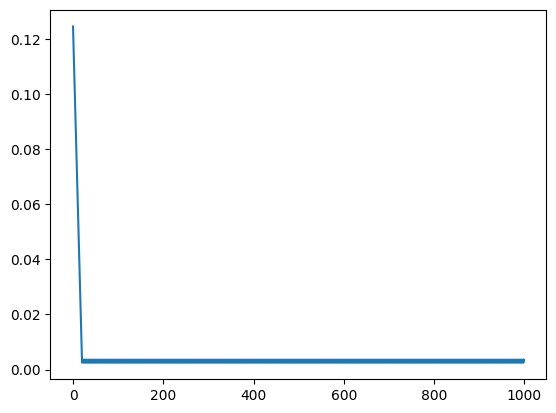

In [16]:
plt.plot(losses)

In [17]:
## Checking backward implementation shapes
zc = (W1 @ X.T + b1[..., None]).T
print(W1.shape, b1.shape, zc.shape)

d_z = zc
d_X = (W1.T @ d_z.T).T
print(d_X.shape, (n_batch, n_in))
d_W = 1 / n_batch * (d_z.T @ X)
print(d_W.shape, (n_h, n_in))
d_b = 1 / n_batch * d_z.sum(dim=0, keepdims=True)
print(d_b.shape, (n_batch, n_h))

torch.Size([3, 2]) torch.Size([3]) torch.Size([1, 3])
torch.Size([1, 2]) (1, 2)
torch.Size([3, 2]) (3, 2)
torch.Size([1, 3]) (1, 3)
